In [1]:
# Import libraries
import xarray as xr
import numpy as np
import os
import pandas as pd
import sys
sys.path.append("/Users/ccamargo/Documents/github/SLB/")

from utils_SLB import cluster_mean, plot_map_subplots, sum_linear, sum_square, get_dectime
from utils_SLB import plot_map2 as plot_map

sys.path.append("/Users/ccamargo/Documents/py_scripts/")
import utils_SL as sl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cm
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
cmap_trend = cm.cm.balance
cmap_unc = cm.tools.crop(cmap_trend,0,3,0)

import seaborn as sns
import scipy.stats as st
# from scipy import stats
import sklearn.metrics as metrics
import random

import warnings
warnings.filterwarnings("ignore","Mean of empty slice", RuntimeWarning)

In [6]:
#%% get budget components
path = '/Volumes/LaCie_NIOZ/data/budget/'
path = '/Users/ccamargo/Desktop/manuscript_SLB/data/'
dic = pd.read_pickle(path+'budget_v2.pkl')


# dimensions
period = ['1993-2017'] # full years
y0,y1=period[0].split('-')
t0='{}-01-01'.format(int(y0))
t1='{}-12-31'.format(int(y1)-1)
path = '/Volumes/LaCie_NIOZ/data/budget/ts/' 
ds = xr.open_dataset(path+'alt.nc')
ds = ds.sel(time=slice(t0,t1))
lat=np.array(ds.lat)
lon=np.array(ds.lon)

tdec = get_dectime(ds.time)
da = ds['sla_ens'][0,:,:]
da = da.where((ds.lat>-66) & (ds.lat<66),np.nan)
# da.plot()
landmask = np.array(da.data)
landmask[np.isfinite(landmask)]=1
# plt.pcolor(landmask)


path_to_figures = '/Users/ccamargo/Desktop/manuscript_SLB/EGU/'


colors_dic = {
    'Altimetry':'mediumseagreen',
    'Sum':'mediumpurple',
    'Steric':'goldenrod',
    'Dynamic':'indianred',
    'Barystatic':'steelblue',
    'Sterodynamic':'palevioletred'}


#%% plot trends for each component
clim=5
cmap=cmap_trend
cmin=-clim;cmax=clim
clabel='Trend \nmm/yr'
lon0=210; offset_y = -0.125;
fontsize=25
nrow=2;ncol=2
lon[-1]=360
fsize=(15,10)
proj='robin'
land=True
grid=False
landcolor='papayawhip'
extent = False
plot_type = 'contour'
interval = 0.1
sig = False

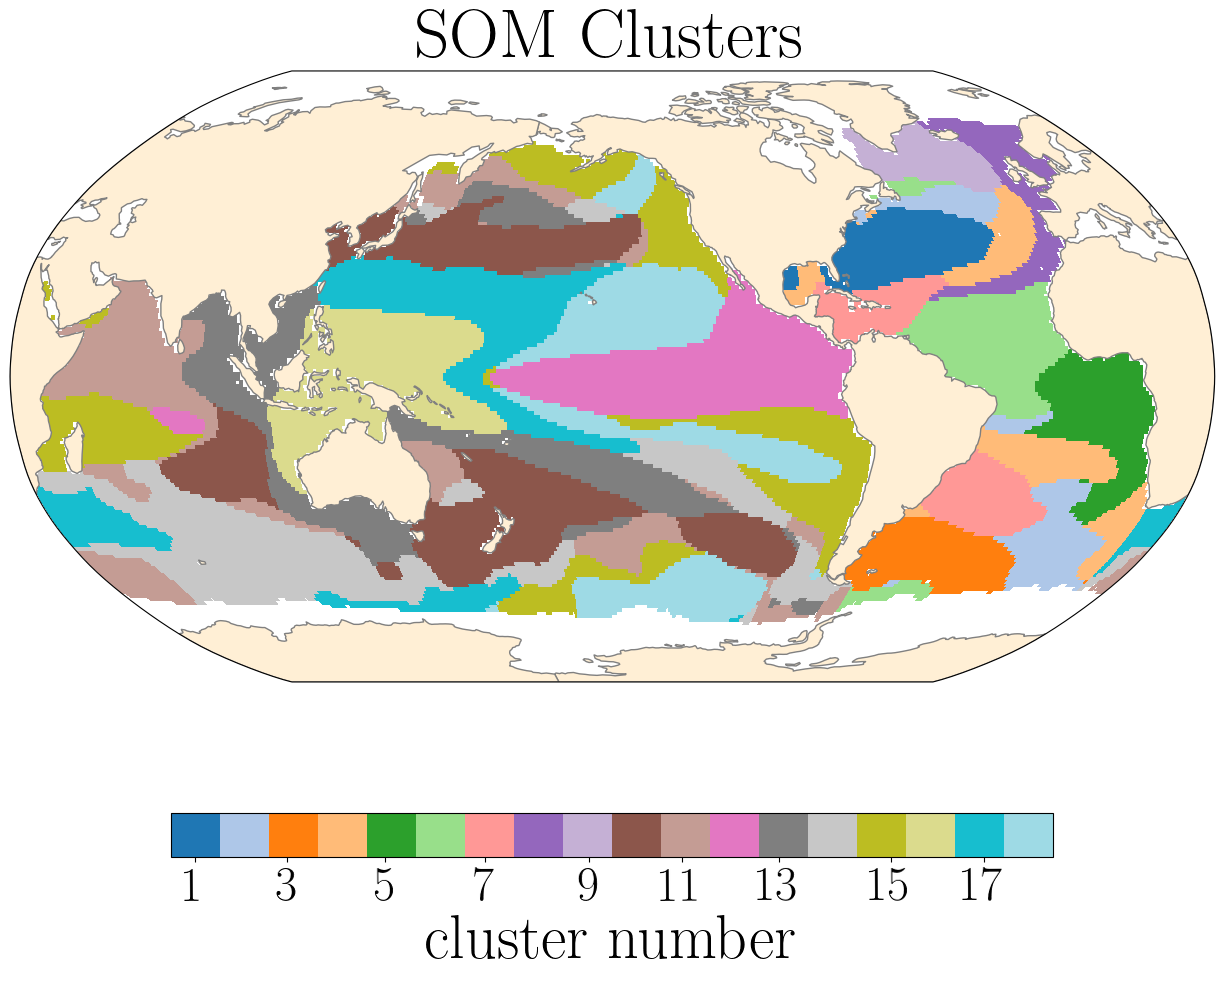

In [33]:
fontsize=50
plot_type = 'pcolor'
nrow = 1
ncol= 1

fig = plt.figure(figsize=fsize,dpi=100)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
proj=ccrs.Robinson(central_longitude=lon0)

# SOM
key='som'
mask_clusters = np.array(dic[key]['mask'])
n_clusters = dic[key]['n']
cmap = 'tab20'
data = np.array(mask_clusters)
title = 'SOM Clusters'    
clabel='cluster number'
cmin = 0 
cmax = 19
idata = 0
cmap = plt.get_cmap(cmap, n_clusters)
ax = plt.subplot(nrow,ncol,idata+1, projection=proj
                     #Mercator()
                     )
ax.set_global()
##             min_lon,,max_lon,minlat,maxlat
if plot_type=='pcolor':
    mm = ax.pcolormesh(lon,\
                       lat,\
                       data,
                       vmin=cmin, vmax=cmax, 
                       transform=ccrs.PlateCarree(),
                       #cmap='Spectral_r'
                       cmap=cmap
                      )
if plot_type =='contour':
    lv=np.arange(cmin,cmax+interval,interval)
    mm=plt.contourf(lon,lat,data,levels=lv,
              transform = ccrs.PlateCarree(),cmap=cmap)

    plt.pcolormesh(lon,lat,data,
            vmin=cmin,vmax=cmax,
            zorder=0,
            transform = ccrs.PlateCarree(),cmap=cmap)

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='gray', facecolor=landcolor))
plt.title(title,fontsize=fontsize)
labels = np.arange(1,cmax,2)
loc    = labels + .5
loc = np.arange(1,19,2)+0.5
loc = np.linspace(0,20)
loc = np.linspace(0.5,19,len(labels))
loc = np.arange(0.5,18,2)
cbar = plt.colorbar(mm,orientation='horizontal',shrink=0.6)
loc = [ 0.5,  2.5,  4.6,  6.75,  9, 11, 13.1, 15.5, 17.5]
cbar.set_label(label=clabel,size=fontsize-5, family='serif')    
cbar.ax.tick_params(labelsize=fontsize-15,labelrotation=0.4) 
cbar.set_ticks(loc)
cbar.set_ticklabels(labels)

plt.tight_layout()


plt.show()

In [34]:
das_res = [dic['res']['trend'],
           dic['dmap']['df']['res_tr'],
           dic['som']['df']['res_tr'],
                ]
das_alt = [dic['alt']['trend'],
           dic['dmap']['df']['alt_tr'],
           dic['som']['df']['alt_tr'],
                ]
das_sum = [dic['sum']['trend'],
           dic['dmap']['df']['sum_tr'],
           dic['som']['df']['sum_tr'],
                ]

das_res_u = [dic['res']['unc'],
           dic['dmap']['df']['res_unc'],
           dic['som']['df']['res_unc'],
                ]

das_sum_u = [dic['sum']['unc'],
           dic['dmap']['df']['sum_unc'],
           dic['som']['df']['sum_unc'],
                ]

das_alt_u = [dic['alt']['unc'],
           dic['dmap']['df']['alt_unc'],
           dic['som']['df']['alt_unc'],
                ]

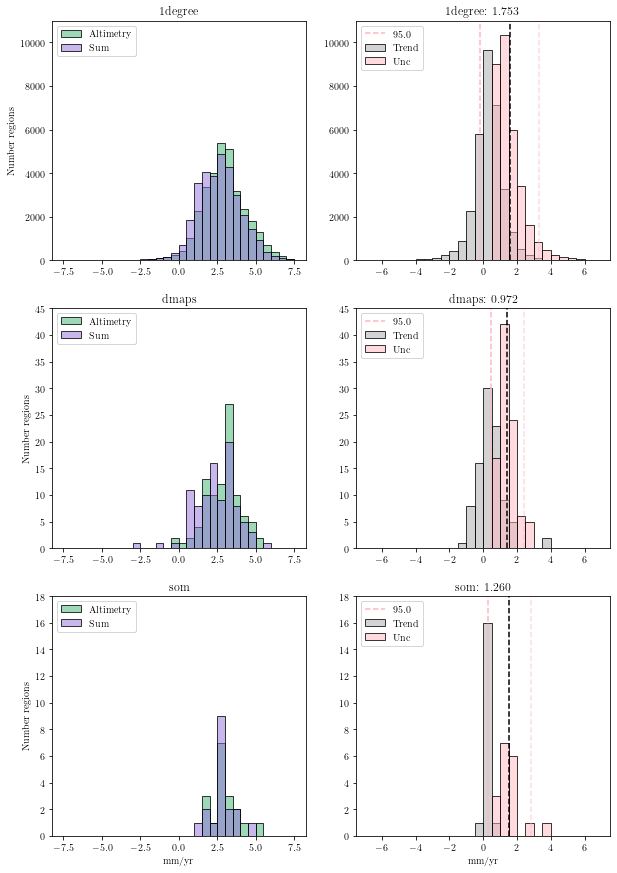

In [35]:
i=0
ws = []
clim=7.5
title=['1degree', 'dmaps', 'som']

pos=[1,3,5]
lims = [(0,11000),(0,45),(0,18)]
fig = plt.figure(figsize=(10,15))
for i in range(3):
    df = pd.DataFrame({'Altimetry':np.hstack(das_alt[i]),
                       'Sum':np.hstack(das_sum[i]),
                      # 'res':np.hstack(adas_res[i])
                      })

    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)

    ax = plt.subplot(3,2,pos[i])
    for name in ['Altimetry','Sum']:
        sns.histplot(df[name],kde=False, #label='Trend',
                     alpha=0.5,
                     label=name,
                     # stat="percent", 
                     color=colors_dic[name],
                    bins=np.arange(-clim, clim+0.1,0.5))
    if i==2:
        plt.xlabel('mm/yr')
    else:
        plt.xlabel('')
    plt.ylabel('Number regions')
    plt.title(title[i])
    plt.ylim(lims[i])
    plt.legend(loc='upper left')
i=0
pos=[2,4,6]
for trend,unc in zip(das_res,das_res_u):
    df= pd.DataFrame( {
                    'Trend':np.hstack(trend),
    'Unc':np.hstack(unc),
    })
    
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df.drop('index',axis=1)
    
    ax = plt.subplot(3,2,pos[i])
    c = {'Trend':'darkgray',
        'Unc':'lightpink'}
    for var in ['Trend','Unc']:
        sns.histplot(df[var],kde=False, #label='Trend',
                     alpha=0.5,
                     color=c[var],
                     label=var,
                     # stat="percent", 
                    bins=np.arange(-clim, clim+0.1,0.5))

    # plt.legend(prop={'size': 12})
    if i==2:
        plt.xlabel('mm/yr')
    else:
        plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-clim,clim)
    
    plt.ylim(lims[i])
    var = 'Unc'
    x = np.array(df[var])
    ci_level=0.95
    ci = st.norm.interval(alpha=ci_level, loc=np.mean(x), scale=x.std())
    plt.axvline(x.mean(),color='k',linestyle='--')

    plt.axvline(ci[0],c=c[var],linestyle='--',alpha=1,label='{}% CI'.format(ci_level*100))
    plt.axvline(ci[1],c=c[var],linestyle='--',alpha=0.5)
    
    ci_width = np.abs(ci[0]-ci[1])/2
    ws.append(ci_width)
    plt.title(title[i]+': {:.3f}'.format( ci_width))
    
    i=i+1
    plt.legend(loc='upper left')
plt.show()   

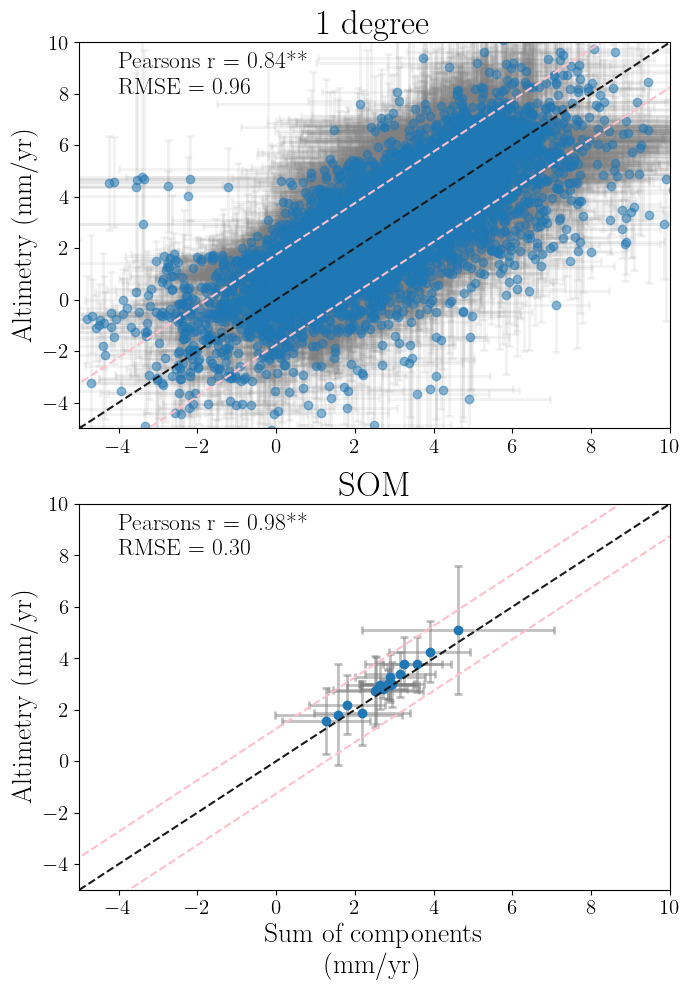

In [48]:
fontsize=25
fig = plt.figure(figsize=(7,10),dpi=100)
nrow=2
ncol=1

key ='som' # cluster
mask = np.array(dic[key]['mask']) # clusters mask
mask_tmp = np.array(mask)
mask_tmp[np.isfinite(mask_tmp)]=1

ax=plt.subplot(nrow,ncol,1)
plt.title('1 degree', fontsize=fontsize)
y = np.array(dic['alt']['trend'] * mask_tmp).flatten() 
x = np.array(dic['sum']['trend'] * mask_tmp).flatten()
yerr = np.array(dic['alt']['unc'] * mask_tmp).flatten() 
xerr = np.array(dic['sum']['unc'] * mask_tmp).flatten()

# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]

y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]



cmin=-5
cmax=10
clim = [cmin,cmax]
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[0]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c="pink")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c="pink")

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             # s=1,
             alpha=0.1,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
            alpha=0.5,
            marker='o',
            # facecolors='none', edgecolors='b'
           )

# plt.xlabel('sum')
plt.ylabel('Altimetry (mm/yr)', fontsize=fontsize-5)

plt.xlim(clim)
plt.ylim(clim)
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
#ax.annotate("$R^2$ = {:.2f}".format(metrics.r2_score(y-np.nanmean(y),x-np.nanmean(x))), (clim[0]+1,clim[1]-3))
r,p = st.pearsonr(xx, yy)
if p<0.05:
    if p<0.0001:
        ax.annotate("Pearsons r = {:.2f}**".format(r), (clim[0]+1,clim[1]-1),fontsize=fontsize-8)
    else:
         ax.annotate("Pearsons r = {:.2f}*".format(r), (clim[0]+1,clim[1]-1),fontsize=fontsize-8)  
else:
     ax.annotate("Pearsons r = {:.2f}".format(r), (clim[0]+1,clim[1]-1),fontsize=fontsize-8)
ax.annotate("RMSE = {:.2f}".format(np.sqrt(metrics.mean_squared_error(y,x))),(clim[0]+1,clim[1]-2),fontsize=fontsize-8 )

# ax.tick_params(axis='both', which='minor', labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
########################
ax=plt.subplot(nrow,ncol,2)
plt.title('SOM', fontsize=fontsize)
key='som'
y = np.array(dic[key]['df']['alt_tr']).flatten()
x = np.array(dic[key]['df']['sum_tr']).flatten()
yerr = np.array(dic[key]['df']['alt_unc']).flatten() 
xerr = np.array(dic[key]['df']['sum_unc']).flatten()
# x  = np.array(x - np.nanmin(x))/ (np.nanmax(x) - np.nanmin(x))
# y  = np.array(y - np.nanmin(y))/ (np.nanmax(y) - np.nanmin(y))

x = x[np.isfinite(y)]
xerr = xerr[np.isfinite(y)]
yerr = yerr[np.isfinite(y)]
y = y[np.isfinite(y)]
y = y[np.isfinite(x)]
xerr = xerr[np.isfinite(x)]
yerr = yerr[np.isfinite(x)]
x = x[np.isfinite(x)]

plt.errorbar(x,y,
             yerr=yerr,
             xerr = xerr,
             #c=c,
             # s=1,
             alpha=0.5,
             zorder=0,
             capsize=3,capthick=2,ecolor='gray',lw=2,fmt='none')
plt.scatter(x,y,
           # marker='o',facecolors='none', edgecolors='b'
           )
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])

clim = [cmin,cmax]
plt.xlim(clim)
plt.ylim(clim)
#plt.plot([-5, 10], [-5, 10], ls="--", c=".3")
plt.plot(clim, clim, ls="--", c=".1")
w=ws[2]/2
plt.plot([cmin-w,cmax-w], [cmin+w,cmax+w], ls="--", c="pink")
plt.plot([cmin+w,cmax+w], [cmin-w,cmax-w], ls="--", c="pink")
plt.xlabel('Sum of components \n(mm/yr)', fontsize=fontsize-5)
plt.ylabel('Altimetry (mm/yr)', fontsize=fontsize-5)
if len(x)>500:
    idx = random.sample(list(np.arange(0,len(x))),500)
    xx = x[idx]
    yy = y[idx]
else:
    xx=x
    yy=y
    
# ax.annotate("$R^2$ = {:.2f}".format(metrics.r2_score(y-np.nanmean(y),x-np.nanmean(x))), (clim[0]+1,clim[1]-3))
r,p = st.pearsonr(xx, yy)
if p<0.05:
    if p<0.0001:
        ax.annotate("Pearsons r = {:.2f}**".format(r), (clim[0]+1,clim[1]-1),fontsize=fontsize-8)
    else:
         ax.annotate("Pearsons r = {:.2f}*".format(r), (clim[0]+1,clim[1]-1),fontsize=fontsize-8)  
else:
     ax.annotate("Pearsons r = {:.2f}".format(r), (clim[0]+1,clim[1]-1),fontsize=fontsize-8)
ax.annotate("RMSE = {:.2f}".format(np.sqrt(metrics.mean_squared_error(y,x))),(clim[0]+1,clim[1]-2),fontsize=fontsize-8 )

ax.tick_params(axis='both', which='major', labelsize=15)
#ax.tick_params(axis='both', which='minor', labelsize=15)

plt.tight_layout()
plt.show()

In [49]:
df = dic['som']['df']
df = pd.DataFrame({'Altimetry':df['alt_tr'],
                  'Altimetry_err':df['alt_unc'],
                   'Sum_err':df['sum_unc'],
                  'Dynamic':df['dynamic_tr'],
                   'Barystatic':df['barystatic_tr'],
                  'Steric':df['steric_tr']})

df['cluster_n'] = [int(i) for i in dic['som']['df']['cluster_n']]
df['Sum'] = df['Steric'] + df['Dynamic'] + df['Barystatic']

df = df.set_index('cluster_n')

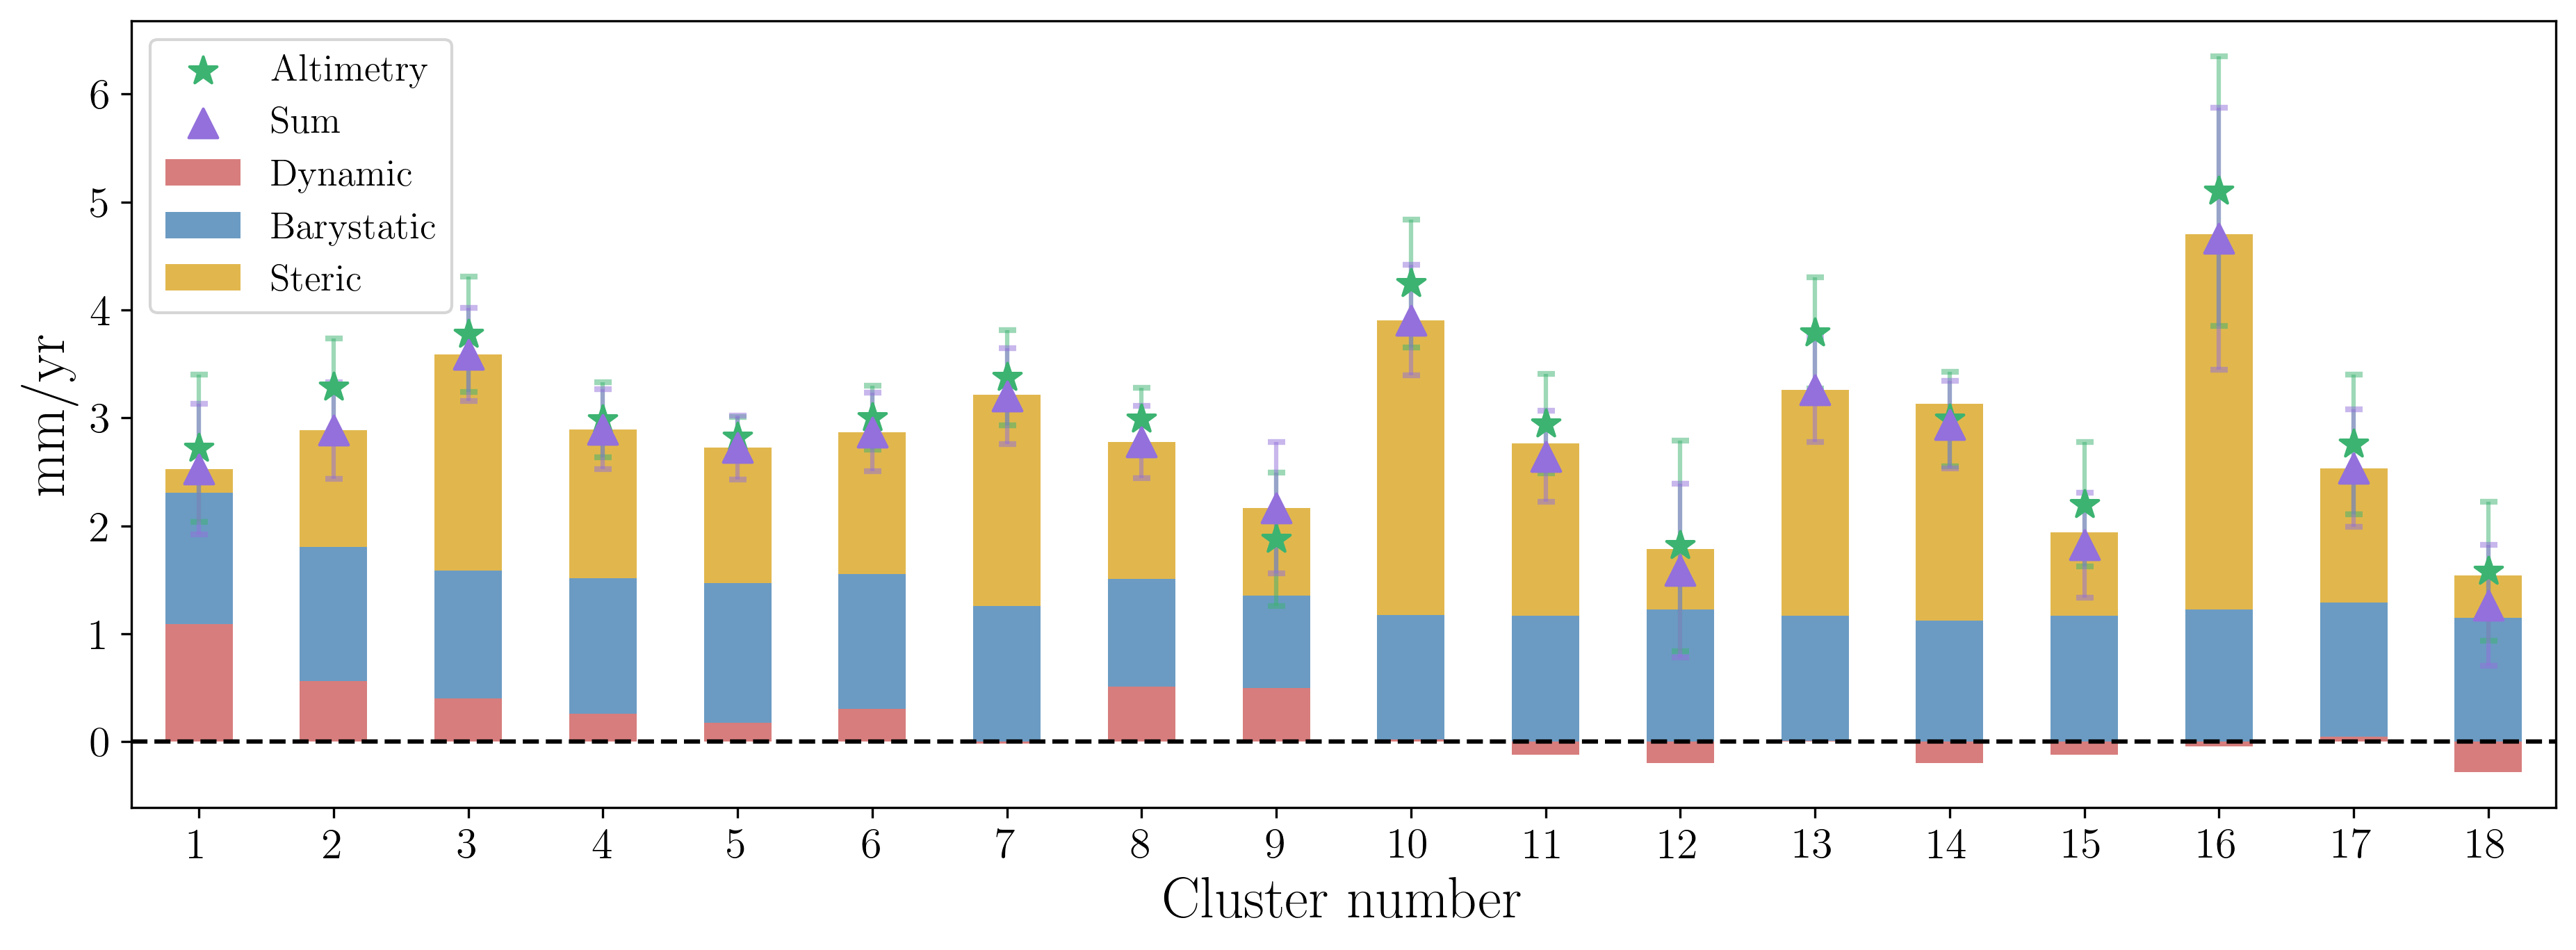

In [60]:
fig = plt.figure(figsize=(15,5),dpi=300)
plt.axhline(0,color='k',linestyle='--')
ax = plt.subplot(111)
comp = ['Dynamic','Barystatic','Steric']
colors = [colors_dic[c] for c in comp]

df[comp].plot(
        kind='bar',
        stacked=True, 
        ax = ax,
        zorder=0,
        alpha=0.8,
        color=colors,
        #edgecolor="k"
)

x = np.arange(len(df))
name = "Altimetry"
y = np.array(df[name])
yerr=df['{}_err'.format(name)]/2
plt.scatter(x,y,marker='*',
            zorder=2,
            s=100,
            color=colors_dic[name],
            label=name)
plt.errorbar(x,y,
             yerr=yerr,
             alpha=0.5,
             capsize=3,capthick=2,
             ecolor=colors_dic[name],
             #lw=2,
             zorder=1,
             fmt='none')

name = "Sum"
y = np.array(df[name])
yerr=df['{}_err'.format(name)]/2
plt.scatter(x,y,marker='^',
            s=100,zorder=3,
            color=colors_dic[name],label=name)
plt.errorbar(x,y,
             yerr=yerr,
             alpha=0.5,
             capsize=3,capthick=2,
             ecolor=colors_dic[name],
             #lw=2,
             zorder=1,
             fmt='none')
plt.legend(fontsize=13,loc = 'upper left')

plt.xlabel('Cluster number',fontsize=20,)
plt.xticks(rotation = 0) 
plt.ylabel('mm/yr',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [64]:
comp = ['Altimetry','Steric','Barystatic','Dynamic']
colors = [colors_dic[c] for c in comp]
var = ['alt','steric','barystatic','dynamic']

da = xr.open_dataset('/Volumes/LaCie_NIOZ/data/budget/ts/alt.nc')
tdec, _ = sl.get_dec_time(da.time)
tdec = tdec[0:288]

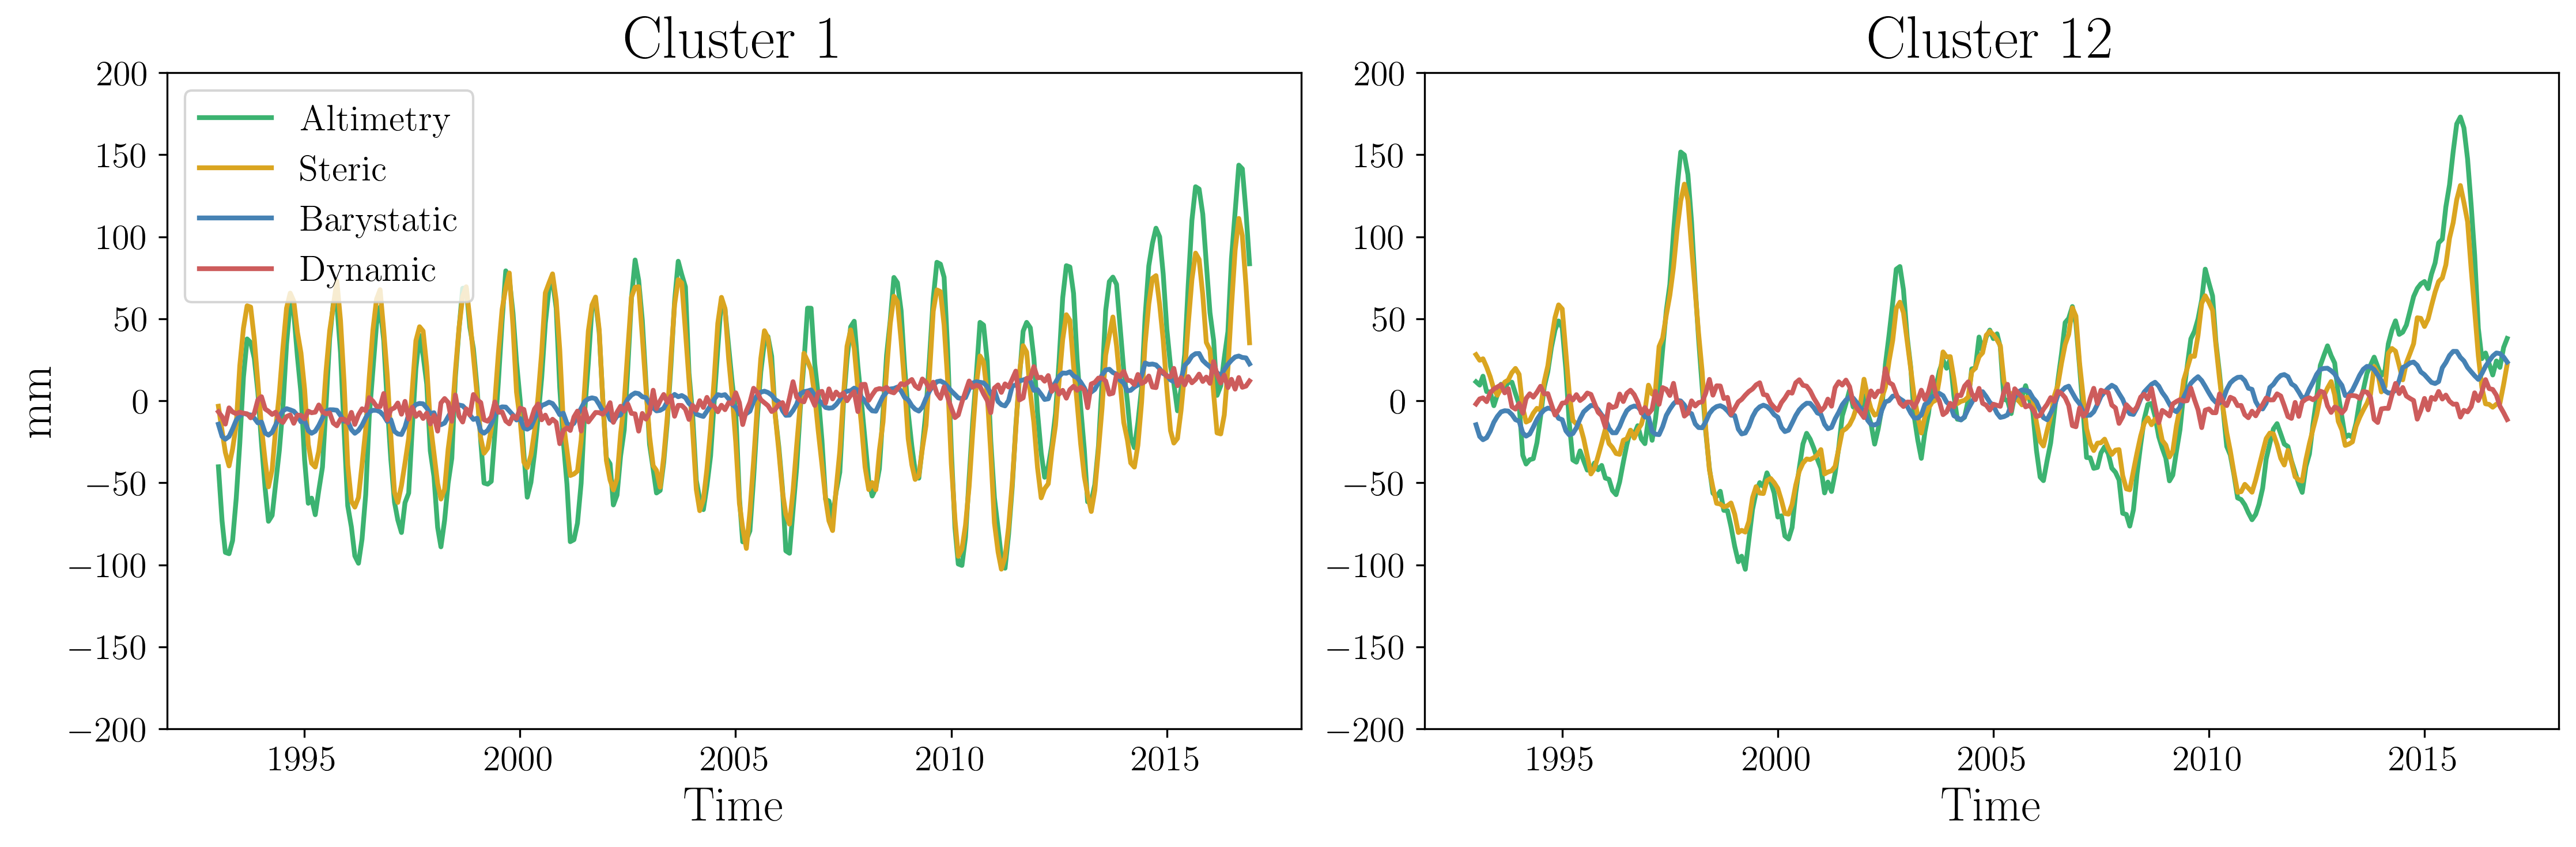

In [68]:
n_cluster = 2
y=1
x=2

ts=np.zeros((n_cluster,len(var),len(tdec)))
tr=np.zeros((n_cluster,len(var)))
i=0
fig = plt.figure(figsize=(15,5),dpi=300)
for icluster in [1,12]:
    mask=np.array(dic['som']['mask'])
    mask[np.where(mask!=icluster)]=np.nan
    mask[np.isfinite(mask)]=1
    # plt.pcolor(mask)
    # plt.show()
    # ampl = np.abs(np.nanmax(da.sla[:,:,:,0]*mask) - np.nanmin(da.sla[:,:,:,0]*mask))
    ax = plt.subplot(y,x,i+1)
    # plt.subplot(111)
    for ivar,v in enumerate(var):
        ts[i,ivar,:] = cluster_mean(np.array(dic[v]['ts']), mask,time=tdec,lat=da.lat,lon=da.lon,norm=True)
        out = sl.get_OLS_trend(tdec,ts[i,ivar])
        tr[i,ivar]=out[0]
        plt.plot(tdec,ts[i,ivar,:],
                 c=colors[ivar],
                 linewidth=2,
                 label='{}'.format(comp[ivar]))
    plt.title('Cluster {}'.format(icluster),fontsize=fontsize)
    plt.ylim(-200,200)
    if icluster ==1:
        plt.legend(fontsize=15)
        plt.ylabel('mm',fontsize=20)

    i=i+1
    plt.xlabel('Time',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()




plt.show()